In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.table import Table
import corner

In [2]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import statistics_ as sta
import mcmc as mcmc_

# Creating fake data assuming a model

We set the true parameters

In [3]:
ptrue = [1,1]

We define the model

In [4]:
def model_MCMC(X,p):
    
    x, y = X[0], X[1]
    
    return p[0]*x + p[1]*y

We create fake data described by the above model introducing fake noise

In [5]:
N = 5
noise = 10
xdimension = 2
x = np.linspace(-10,10,N)
y = np.linspace(-10,10,N)
Xdata = [x, y]
X = mcmc_.combinatory(Xdata)
y_exp = model_MCMC(X,ptrue) + np.random.randn(N**xdimension)*noise

We store the `x` data and `y` measured data in an `astropy` table

In [6]:
t = Table()
t['x0'] = X[0]
t['x1'] = X[1]
t['y'] = y_exp

# Covariance Matrix

We create arbitrary covariance matrix

In [7]:
Stat = sta.Statistics(N*N)

In [8]:
for i in range(100):
    
    y_real = model_MCMC([t['x0'],t['x1']],ptrue) + np.random.randn(N**xdimension)*noise
    
    Stat._add_realization(y_real)

In [9]:
Stat.covariance()
cov = Stat.covariance

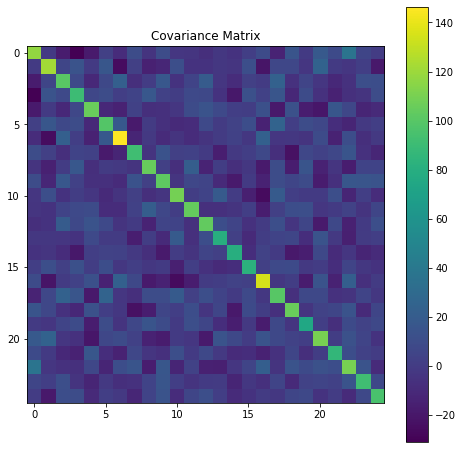

In [10]:
fig = plt.figure(figsize = (8,8))
plt.imshow(cov)
plt.title('Covariance Matrix')
plt.colorbar()
plt.show()

# Fit parameters using MCMC

In [11]:
MCMC = mcmc_.MCMC(n_parameters = 2)

We add data information to the `MCMC` object

In [12]:
MCMC._set_data(t)
MCMC._set_covariance_matrix(cov)
MCMC._set_model(model_MCMC)

We set bounds for parameter space

In [13]:
MCMC._set_lnprior_bounds(bounds = [[-0,2],[-0,2]])

We intitialize the random walks and find out the stating point of the official random walks by running first short MCMC

In [14]:
MCMC._set_walkers(n_walkers = 100, n_step = 200)
MCMC._set_initial_condition(np.array([1,1]), np.array([0.001,0.001]))
MCMC.run_MCMC()
MCMC._discard(tau = 50)
MCMC.fit_symmetric()

100%|██████████| 200/200 [00:07<00:00, 26.92it/s]


Second, we run last MCMC with intitial position estimated above

In [15]:
MCMC._set_walkers(n_walkers = 100, n_step = 500)
MCMC._set_initial_condition(MCMC.mean_symmetric, MCMC.error_symmetric)
MCMC.run_MCMC()

  0%|          | 0/500 [00:00<?, ?it/s]/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:22<00:00, 21.93it/s]


In [16]:
MCMC._discard(tau = 30)

We plot the corner plot to display the last sample

<Figure size 432x288 with 0 Axes>

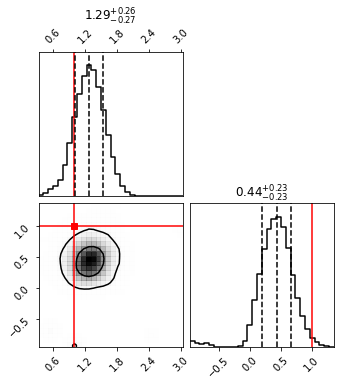

In [17]:
from corner import corner
fig = plt.figure()
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
fig = corner(MCMC.samples\
             ,reverse = False,\
            bins = 30,\
             smooth = True,\
             plot_datapoints=False,levels=(sigma1, sigma2), \
             #labels =use_params,\
             quantiles=[0.16, 0.5, 0.84], \
             color='k',\
             #range = use_ranges,\
         show_titles = True, \
        truths =np.array(ptrue),\
         truth_color='r', smooth1d = 1, top_ticks = True)

## There is two ways to estimate parameters:

Using MCMC assymmetry due to true PDF of parameters:

In [18]:
MCMC.fit_MCMC()
popt, cov = MCMC.mean_MCMC, MCMC.error_MCMC
print('x = ' + str(popt) + ' +/- ' + str(cov))

x = [1.28508276 0.43599935] +/- [[0.27063702 0.26234381]
 [0.2319272  0.22771111]]


Using mean and covariance matrix:

In [19]:
MCMC.fit_symmetric()
popt, cov = MCMC.mean_symmetric, MCMC.error_symmetric
print('x = ' + str(popt) + ' +/- ' + str(cov))

x = [1.2834005  0.42229354] +/- [0.27247712 0.2871378 ]
